# RNNs in pytorch

We will construct a character-level RNN which will classify names according to their language. Based on [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [1]:
from torch import nn
import torch
from pathlib import Path
import unicodedata
import string
import os
import random
import time
import math
from tqdm import tqdm
import matplotlib.ticker as ticker


Bad key backend.qt4 in file /etc/matplotlib/matplotlibrc, line 43 ('backend.qt4 : PyQt4        # PyQt4 | PySide')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


Get data

In [2]:
# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip 
# !rm data.zip
# !mkdir -p data/rnn
# !mv data/names data/rnn
# !mv data/*.txt data/rnn

In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [4]:
data_dir = Path('data/rnn/names')
list(data_dir.glob('*.txt'))

[PosixPath('data/rnn/names/Arabic.txt'),
 PosixPath('data/rnn/names/Chinese.txt'),
 PosixPath('data/rnn/names/Czech.txt'),
 PosixPath('data/rnn/names/Dutch.txt'),
 PosixPath('data/rnn/names/English.txt'),
 PosixPath('data/rnn/names/French.txt'),
 PosixPath('data/rnn/names/German.txt'),
 PosixPath('data/rnn/names/Greek.txt'),
 PosixPath('data/rnn/names/Irish.txt'),
 PosixPath('data/rnn/names/Italian.txt'),
 PosixPath('data/rnn/names/Japanese.txt'),
 PosixPath('data/rnn/names/Korean.txt'),
 PosixPath('data/rnn/names/Polish.txt'),
 PosixPath('data/rnn/names/Portuguese.txt'),
 PosixPath('data/rnn/names/Russian.txt'),
 PosixPath('data/rnn/names/Scottish.txt'),
 PosixPath('data/rnn/names/Spanish.txt'),
 PosixPath('data/rnn/names/Vietnamese.txt')]

In [5]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

Construct a dictionary of lists of names per language: `{language: [names ...]}`

In [6]:
category_lines = {}
all_categories = []
for filename in data_dir.glob('*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [7]:
category_lines.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [8]:
category_lines['French'][:3]

['Abel', 'Abraham', 'Adam']

In [9]:
category_lines['English'][:3]

['Abbas', 'Abbey', 'Abbott']

So we have a dataset of `language: words`.

In [10]:
n_names = list(len(category_lines[lang]) for lang in all_categories)
min(n_names), max(n_names)

(73, 9408)

## Turning names into tensors

We one-hot encode each character, and then construct words to be 2D matrices of dimensions `<line_length x 1 x n_letters>`.

In [11]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# as an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

In [12]:
assert line_to_tensor('abc').size() == (len('abc'), 1, n_letters)

## Creating a network

An RNN can be written as
$$h_t  = \sigma_h(W_h x_t + U_h h_{t-1} + b_h)$$
$$y_t  = \sigma_y(W_y h_t + b_y)$$
in the code below, we instead concatenate $x_t$ and $h_{t-1}$ together to make a single matrix in `self.i2h`. It's the same thing.



In [13]:
from collections import namedtuple

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # addition because we concatenate together the input and the hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
        Sizes = namedtuple('Sizes', ['input', 'hidden', 'output'])
        self.sizes = Sizes(input_size, hidden_size, output_size) 

    def forward(self, x_in, hidden):
        combined = torch.cat((x_in, hidden), 1)
        hidden = self.i2h(combined)
        # assert hidden.size() == (1, self.sizes.hidden), hidden.size()
        
        output = self.i2o(combined)
        output = self.softmax(output)
        # assert output.size() == (1, self.sizes.output), output.size()
        
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [14]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [15]:
rnn.sizes

Sizes(input=57, hidden=128, output=18)

To run a step of `RNN`, we need to pass an input (in this case, the tensor for the current letter) and a previous hidden state. 

We get back the output (probability of each language) and the next hidden state

In [16]:
x_in = line_to_tensor('A')[0]
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x_in, hidden)

In [17]:
assert output.size() == (1, n_categories)

In [18]:
assert next_hidden.size() == (1, n_hidden)

## Training

In [19]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [20]:
category_from_output(output)

('Arabic', 0)

In [21]:
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    assert category_tensor.size() == (1,)
    
    line_tensor = line_to_tensor(line)
    assert line_tensor.size() == (len(line), 1, n_letters), line_tensor.size()
    return category, line, category_tensor, line_tensor

In [22]:
for i in range(10): 
    category, line, category_tensor, line_tensor = random_training_example()
    print('category =', category, '/ line =', line)

category = English / line = Sissons
category = Portuguese / line = Alves
category = Vietnamese / line = Vo
category = Dutch / line = Michel
category = English / line = Addinall
category = Chinese / line = Zhi
category = Czech / line = Fritsch
category = German / line = Hoffman
category = Irish / line = Madden
category = Korean / line = Yi


### Training the network

In [23]:
criterion = nn.NLLLoss()  # negative log likelihood loss

In [24]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    # zero the hidden state. State is only retained within the particular line!
    # The length of the hidden state is fixed (defined by the vocabulary size)
    hidden = rnn.init_hidden()  
    rnn.zero_grad()
    
    # train on a new name, 1 letter at a time. The size of this loop *varies* between names
    # meaning that the number of times you "recur" is not fixed!
    for i in range(line_tensor.size()[0]):  
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # add parameters' gradients to view their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
    
    return output, loss.item()

We now train this on many random examples to learn the parameters of the model

In [25]:
rnn.parameters

<bound method Module.parameters of RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)>

In [26]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

n_iters = 100000
plot_every = 1000

In [27]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [28]:
start = time.time()

for i in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0
    

100%|██████████| 100000/100000 [03:31<00:00, 473.47it/s]


### Visualize loss

In [29]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Iteration')

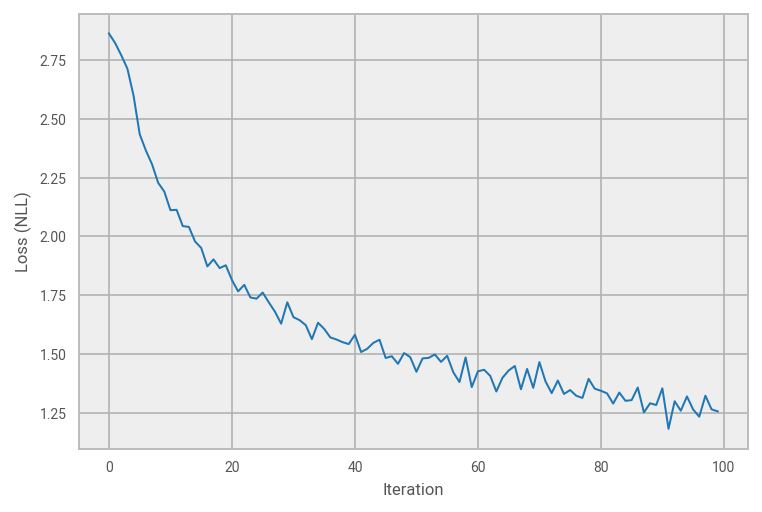

In [30]:
fig, ax = plt.subplots()
ax.plot(all_losses)
ax.set_ylabel('Loss (NLL)')
ax.set_xlabel('Iteration')

## Evaluate model

In [31]:
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print(f'\n> {input_line}')
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)        
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f'({value:.2f}) {all_categories[category_index]}')
        

100%|██████████| 10000/10000 [00:09<00:00, 1089.06it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


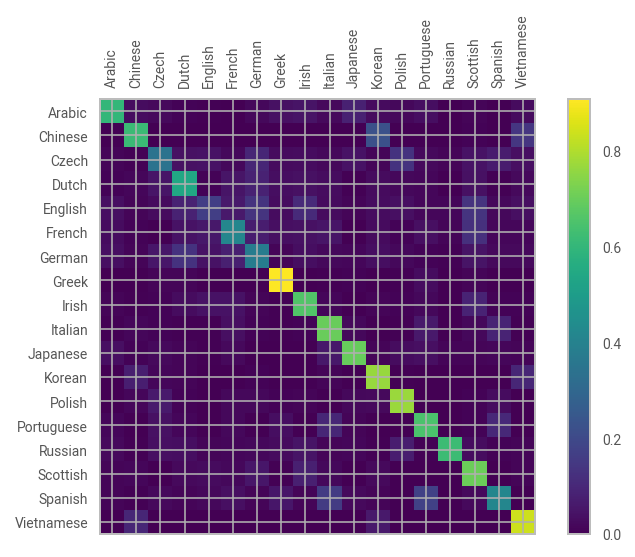

In [32]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
for i in tqdm(range(n_confusion)):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

## Inference

In [33]:
predict('Dostoevsky')
predict('Jackson')
predict('Satoshi')


> Dostoevsky
(-0.21) Russian
(-2.20) Czech
(-3.51) English

> Jackson
(-0.72) Scottish
(-1.29) English
(-2.32) Russian

> Satoshi
(-1.04) Italian
(-1.08) Japanese
(-1.94) Arabic


---

## Using the pytorch RNN API

In [34]:
class ClassifyCharacterRNN(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, output_size: int, 
                 batch_first=False, *args, **kwargs):
        super().__init__()
        
        self.rnn = nn.RNN(vocab_size, hidden_size, *args, **kwargs)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        Sizes = namedtuple('Sizes', ['vocab', 'hidden', 'output'])                
        
        self.sizes = Sizes(vocab=vocab_size, 
                           hidden=hidden_size,                            
                           output=output_size,
                          ) 
    
    def forward(self, x_in):
        sequence_length, batch_size, _ = x_in.size()
        # assert x_in.size() == (sequence_length, batch_size, self.sizes.vocab)
        
        h0 = self.init_hidden(batch_size)
        # assert h0.size() == (1, batch_size, self.sizes.hidden)
        
        output, h_n = self.rnn(x_in, h0)
        
        # assert output.size() == (sequence_length, batch_size, self.sizes.hidden), output.size()
        
        # only want logits on the final prediction after seeing
        # the whole sequence (name/word)
        logits = self.h2o(output[-1, ...])  
        
        probs = self.softmax(logits)        
        return probs
    
    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.sizes.hidden)
    

In [35]:
n_hidden = 128
clf_rnn = ClassifyCharacterRNN(n_letters, n_hidden, n_categories)

In [36]:
x_in = line_to_tensor('Alice')
probs = clf_rnn(x_in)
probs.shape

torch.Size([1, 18])

In [37]:
def train_clf_rnn(category_tensor, line_tensor):    
    clf_rnn.zero_grad()
            
    probs = clf_rnn(line_tensor)    
    loss = criterion(probs, category_tensor)
    loss.backward()
    
    # add parameters' gradients to view their values, multiplied by learning rate
    for p in clf_rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
    
    return probs, loss.item()

In [38]:
clf_rnn.parameters

<bound method Module.parameters of ClassifyCharacterRNN(
  (rnn): RNN(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)>

In [39]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [40]:
start = time.time()

for i in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train_clf_rnn(category_tensor, line_tensor)
    current_loss += loss
    
    # Add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0
    

100%|██████████| 100000/100000 [08:46<00:00, 189.98it/s]


Text(0.5, 0, 'Iteration')

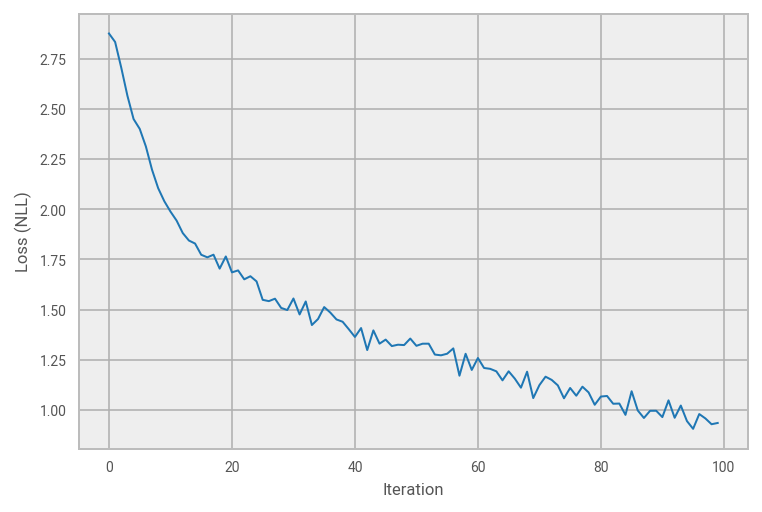

In [41]:
fig, ax = plt.subplots()
ax.plot(all_losses)
ax.set_ylabel('Loss (NLL)')
ax.set_xlabel('Iteration')

In [47]:
def predict(input_line, n_predictions=3):
    print(f'\n> {input_line}')
    
    with torch.no_grad():
        probs = clf_rnn(line_to_tensor(input_line))
        
        topv, topi = probs.topk(n_predictions, 1, True)        
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f'({value:.2f}) {all_categories[category_index]}')
        

100%|██████████| 10000/10000 [00:05<00:00, 1724.42it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


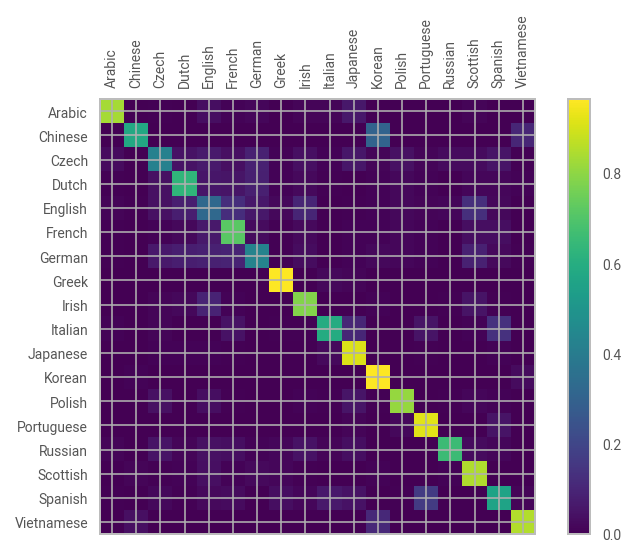

In [43]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
for i in tqdm(range(n_confusion)):
    category, line, category_tensor, line_tensor = random_training_example()
    output = clf_rnn(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [48]:
predict('Dostoevsky')
predict('Jackson')
predict('Satoshi')


> Dostoevsky
(-1.08) Russian
(-1.35) English
(-1.37) Czech

> Jackson
(-0.50) Scottish
(-1.08) English
(-4.27) Russian

> Satoshi
(-0.53) Japanese
(-1.79) Arabic
(-2.42) Italian
